In this document we&rsquo;ll work through a simple approach to estimating
Constant Frisch Elasticity (CFE) demand systems.

There are two prerequisites; the first is the `CFEDemands` python
module.  You may have this already, but if not it  can be installed with a simple:



In [36]:
#!pip install -r requirements.txt

The second prerequisite is a dataset including detailed information on
household expenditures and characteristics.  The structure of that
dataset is detailed in the next section.



## Data



Consider the case in which the data are saved in a google sheet; we&rsquo;ll
turn data from these into `pandas` dataframes.  
There are limits on the allowable size of google sheets (5 million
cells when I last checked), so if your dataset is larger than this you&rsquo;ll need some other
mechanism to get your data into such dataframes.  Even in this latter
case you&rsquo;ll want your dataframes to have a structure that matches the
description given below.



### Structure of the Spreadsheet



An example spreadsheet with data for Uganda can be found at
[https://docs.google.com/spreadsheets/d/1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ/](https://docs.google.com/spreadsheets/d/1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ/)

This spreadsheet consists of three worksheets, labeled &ldquo;RDI&rdquo;, &ldquo;FCT&rdquo;,
&ldquo;Household Characteristics&rdquo;, &ldquo;Prices&rdquo;, and a series of different years of food &ldquo;Expenditures&rdquo;.

Each worksheet has the initial three columns labeled &ldquo;i&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;i&rdquo;
should include a household id; the column &ldquo;t&rdquo; should include an
indicator for the year or period (for those of you with
cross-sectional data these will all take a common value, e.g., 2019);
the column &ldquo;m&rdquo; should be an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Malawi&rdquo;).

The triple (i,t,m) will serve as the index of some constructed
dataframes.  It is important not to have **too** many different values
for &ldquo;m&rdquo; (unless you have lots of data and RAM to play with).

Beyond the first three columns, the &ldquo;Expenditures&rdquo; worksheet for a given year should
have one column for each category of expenditures (e.g., &ldquo;Beans&rdquo;, &ldquo;Beef&rdquo;, &ldquo;Beer&rdquo;,&#x2026;).

Beyond the first three columns, the &ldquo;Household Characteristics&rdquo; should
have columns corresponding to different elements of the vector of
observable characteristics $z$.  If the data allow, I recommend
constructing observables that match what I have in these data:
namely numbers of different children by age and sex, along with the
logarithm of total household size (&ldquo;log HSize&rdquo;).



### From Sheet to DataFrame to Result Object



We begin by defining a dictionary that contains the spreadsheet key. 
One is provided for the Ugandan example that I wish to work
through.



In [37]:
#Uganda_Data = '1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ'

With the spreadsheet defined , grab it and define a couple of
dataframes. (Sheets should be shared with `students@eep153.iam.gserviceaccount.com`):



In [38]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

In [40]:
x = read_sheets('https://docs.google.com/spreadsheets/d/1POplhyd44h-Zt8jMhXa2FGAzS051TPoLa2xMlmvVLU0/edit#gid=1822599829',sheet='Expenditures')
#x = x.set_index(['i','t','m','j']).squeeze().unstack('j')
rural = x.where(x['m']=="Mainland Rural").dropna()
urban = x.where(x['m']=="Mainland Other Urban").dropna()
capital = x.where(x['m']=="Dar Es Salaam").dropna()

rural = rural.pivot_table(values='value_purchase', index=['i','t','m'], columns='j', aggfunc='first').reset_index()
urban = urban.pivot_table(values='value_purchase', index=['i','t','m'], columns='j', aggfunc='first').reset_index()
capital = capital.pivot_table(values='value_purchase', index=['i','t','m'], columns='j', aggfunc='first').reset_index()

# Change 'Uganda' to key of your own sheet in Sheets, above
#d = read_sheets('https://docs.google.com/spreadsheets/d/1POplhyd44h-Zt8jMhXa2FGAzS051TPoLa2xMlmvVLU0/edit#gid=1822599829',sheet="HH Characteristics")
household = read_sheets('https://docs.google.com/spreadsheets/d/1POplhyd44h-Zt8jMhXa2FGAzS051TPoLa2xMlmvVLU0/edit#gid=1822599829',sheet="HH Characteristics")
household.columns.name = 'k'
household.set_index(['i','t','m'],inplace=True)

# x may have duplicate columns
rural = rural.groupby('j',axis=1).sum()
rural = rural.replace(0,np.nan) # Replace zeros with missing
rural = rural.set_index(['i','t','m'])
rural = rural.apply(pd.to_numeric, errors='coerce')

urban = urban.groupby('j',axis=1).sum()
urban = urban.replace(0,np.nan) # Replace zeros with missing
urban = urban.set_index(['i','t','m'])
urban = urban.apply(pd.to_numeric, errors='coerce')

capital = capital.groupby('j',axis=1).sum()
capital = capital.replace(0,np.nan) # Replace zeros with missing
capital = capital.set_index(['i','t','m'])
capital = capital.apply(pd.to_numeric, errors='coerce')

# Take logs of expenditures; call this y
log_rural = np.log(rural)
log_urban = np.log(urban)
log_capital = np.log(capital)

Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


Adapted from example: <br>
&nbsp;&nbsp;&nbsp;&nbsp;Two different $x$: "rural" and "urban" <br>
&nbsp;&nbsp;&nbsp;&nbsp;Subsequently two different $y$: "log_rural" and "log_urban" <br>
&nbsp;&nbsp;&nbsp;&nbsp;$d$ is now "household"

This gives a dataframe of household characteristics $d$ with a simple structure.



In [41]:
household.head()

k                         Females 00-03  Females 04-08  Females 09-13  \
i t       m                                                             
1 2012-13 Mainland Rural            0.0            0.0            0.0   
  2014-15 Mainland Rural            0.0            0.0            0.0   
2 2014-15 Mainland Rural            0.0            0.0            0.0   
4 2012-13 Mainland Rural            1.0            1.0            0.0   
  2014-15 Mainland Rural            0.0            2.0            0.0   

k                         Females 14-18  Females 19-30  Females 31-50  \
i t       m                                                             
1 2012-13 Mainland Rural            0.0            0.0            0.0   
  2014-15 Mainland Rural            0.0            0.0            0.0   
2 2014-15 Mainland Rural            0.0            1.0            0.0   
4 2012-13 Mainland Rural            0.0            1.0            0.0   
  2014-15 Mainland Rural            0.0            1.0            0.0   

k                         Females 51-99  Males 00-03  Males 04-08  \
i t       m                                                         
1 2012-13 Mainland Rural            1.0          0.0          0.0   
  2014-15 Mainland Rural            1.0          0.0          0.0   
2 2014-15 Mainland Rural            0.0          1.0          0.0   
4 2012-13 Mainland Rural            0.0          0.0          0.0   
  2014-15 Mainland Rural            0.0          1.0          0.0   

k                         Males 09-13  Males 14-18  Males 19-30  Males 31-50  \
i t       m                                                                    
1 2012-13 Mainland Rural          0.0          0.0          2.0          0.0   
  2014-15 Mainland Rural          0.0          0.0          1.0          1.0   
2 2014-15 Mainland Rural          0.0          0.0          1.0          0.0   
4 2012-13 Mainland Rural          0.0          0.0          0.0          1.0   
  2014-15 Mainland Rural          0.0          0.0          0.0          1.0   

k                         Males 51-99  log HSize  Rural  
i t       m                                              
1 2012-13 Mainland Rural          1.0   1.386294    1.0  
  2014-15 Mainland Rural          1.0   1.386294    1.0  
2 2014-15 Mainland Rural          0.0   1.098612    1.0  
4 2012-13 Mainland Rural          0.0   1.386294    1.0  
  2014-15 Mainland Rural          0.0   1.609438    1.0

Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



In [42]:
log_rural.head()

j                             Beef  Bottled beer  Bread  Butter  \
i t       m                                                       
1 2008-09 Mainland Rural  7.824046           NaN    NaN     NaN   
  2010-11 Mainland Rural       NaN           NaN    NaN     NaN   
  2012-13 Mainland Rural  7.600902           NaN    NaN     NaN   
  2014-15 Mainland Rural       NaN           NaN    NaN     NaN   
  2019-20 Mainland Rural  7.824046           NaN    NaN     NaN   

j                         Canned milk/milk powder  \
i t       m                                         
1 2008-09 Mainland Rural                      NaN   
  2010-11 Mainland Rural                      NaN   
  2012-13 Mainland Rural                      NaN   
  2014-15 Mainland Rural                      NaN   
  2019-20 Mainland Rural                      NaN   

j                         Canned, dried and wild vegetables  \
i t       m                                                   
1 2008-09 Mainland Rural                                NaN   
  2010-11 Mainland Rural                                NaN   
  2012-13 Mainland Rural                                NaN   
  2014-15 Mainland Rural                                NaN   
  2019-20 Mainland Rural                                NaN   

j                         Cassava dry/flour  Cassava fresh  Chicken  \
i t       m                                                           
1 2008-09 Mainland Rural                NaN            NaN      NaN   
  2010-11 Mainland Rural                NaN            NaN      NaN   
  2012-13 Mainland Rural                NaN            NaN      NaN   
  2014-15 Mainland Rural                NaN            NaN      NaN   
  2019-20 Mainland Rural                NaN            NaN      NaN   

j                         Citrus fruits  ...  Wheat, barley, other grains  \
i t       m                              ...                                
1 2008-09 Mainland Rural            NaN  ...                          NaN   
  2010-11 Mainland Rural            NaN  ...                          NaN   
  2012-13 Mainland Rural            NaN  ...                          NaN   
  2014-15 Mainland Rural            NaN  ...                          NaN   
  2019-20 Mainland Rural            NaN  ...                          NaN   

j                         Wild birds and insects  Wine and spirits  \
i t       m                                                          
1 2008-09 Mainland Rural                     NaN               NaN   
  2010-11 Mainland Rural                     NaN               NaN   
  2012-13 Mainland Rural                     NaN               NaN   
  2014-15 Mainland Rural                     NaN               NaN   
  2019-20 Mainland Rural                     NaN               NaN   

j                         Yams/cocoyams  bread  eggs  salt  sugar  sugarcane  \
i t       m                                                                    
1 2008-09 Mainland Rural            NaN    NaN   NaN   NaN    NaN        NaN   
  2010-11 Mainland Rural            NaN    NaN   NaN   NaN    NaN        NaN   
  2012-13 Mainland Rural            NaN    NaN   NaN   NaN    NaN        NaN   
  2014-15 Mainland Rural            NaN    NaN   NaN   NaN    NaN        NaN   
  2019-20 Mainland Rural            NaN    NaN   NaN   NaN    NaN        NaN   

j                         sweets  
i t       m                       
1 2008-09 Mainland Rural     NaN  
  2010-11 Mainland Rural     NaN  
  2012-13 Mainland Rural     NaN  
  2014-15 Mainland Rural     NaN  
  2019-20 Mainland Rural     NaN  

[5 rows x 67 columns]

In [43]:
log_urban.head()

,,j,Beef,Bottled beer,Bread,Butter,Canned milk/milk powder,"Canned, dried and wild vegetables",Cassava dry/flour,Cassava fresh,Chicken,Citrus fruits,...,Wheat (flour),Wild birds and insects,Wine and spirits,Yams/cocoyams,bread,eggs,salt,sugar,sugarcane,sweets
i,t,m,,,,,,,,,,,,,,,,,,,,,
10003,2012-13,Mainland Other Urban,8.160518,NaN,NaN,NaN,NaN,NaN,NaN,5.298317,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10004,2012-13,Mainland Other Urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.991465,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10005,2012-13,Mainland Other Urban,9.952278,NaN,NaN,NaN,NaN,NaN,NaN,6.684612,8.517193,4.60517,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10006,2012-13,Mainland Other Urban,8.160518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10008,2012-13,Mainland Other Urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.214608,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
log_capital.head()

,,j,Beef,Bottled beer,Bread,Butter,Canned milk/milk powder,"Canned, dried and wild vegetables",Cassava dry/flour,Cassava fresh,Chicken,Citrus fruits,...,"Wheat, barley, other grains",Wild birds and insects,Wine and spirits,Yams/cocoyams,bread,eggs,salt,sugar,sugarcane,sweets
i,t,m,,,,,,,,,,,,,,,,,,,,,
10009,2012-13,Dar Es Salaam,9.392662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.991465,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10086,2012-13,Dar Es Salaam,NaN,NaN,7.863267,NaN,NaN,NaN,NaN,8.006368,NaN,7.003065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10094,2012-13,Dar Es Salaam,NaN,NaN,6.907755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10104,2012-13,Dar Es Salaam,9.798127,NaN,8.294050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10107,2012-13,Dar Es Salaam,8.922658,NaN,NaN,NaN,7.600902,NaN,NaN,NaN,7.600902,8.411833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There may be some goods that very few people consume&#x2014;too few to estimate demand reliably.   We have code to deal with this.  You can play with the `min_obs` parameter&#x2014;the larger it is, the more foods will be dropped.



In [45]:
from cfe.estimation import drop_columns_wo_covariance

log_rural = drop_columns_wo_covariance(log_rural,min_obs=30)
log_urban = drop_columns_wo_covariance(log_urban,min_obs=30)
log_capital = drop_columns_wo_covariance(log_capital,min_obs=30)

Now, we want the $d$ and $y$ dataframes to have rows that line up:



In [46]:
use_rural = log_rural.index.intersection(household.index)
log_rural = log_rural.loc[use_rural,:]
household_rural = household.loc[use_rural,:]

use_urban = log_urban.index.intersection(household.index)
log_urban = log_urban.loc[use_urban,:]
household_urban = household.loc[use_urban,:]

use_capital = log_capital.index.intersection(household.index)
log_capital = log_capital.loc[use_capital,:]
household_capital = household.loc[use_capital,:]

## Estimation



Let $y_{i}^j$ be log expenditures on food $j$ by household $i$ at a particular time.  We want to estimate a regression that takes the form
$$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$
So, a first step is to turn our dataframe for `y` into a series, so we can put it on the left-hand side of this regression.  Then we need to make our dataframe $d$ conform:



In [47]:
log_rural = log_rural.stack()
log_urban = log_urban.stack()
log_capital = log_capital.stack()

household_rural = household_rural.stack()
household_urban = household_urban.stack()
household_capital = household_capital.stack()

In [48]:
# Check that indices are in right places!
assert log_rural.index.names == ['i','t','m','j']
assert log_urban.index.names == ['i','t','m','j']
assert log_capital.index.names == ['i','t','m','j']

assert household_rural.index.names == ['i','t','m','k']
assert household_urban.index.names == ['i','t','m','k']
assert household_capital.index.names == ['i','t','m','k']

### Basic Estimation



Just one line to set up the regression:



In [49]:
# Add this line of code to get rid of repeat indices
idx_rural = np.unique(household_rural.index.values, return_index = True)[1] 
household_rural = household_rural.iloc[idx_rural]

idx_urban = np.unique(household_urban.index.values, return_index = True)[1] 
household_urban = household_urban.iloc[idx_urban]

idx_capital = np.unique(household_capital.index.values, return_index = True)[1] 
household_capital = household_capital.iloc[idx_capital]

In [50]:
from cfe import Regression

result_rural = Regression(y=log_rural,d=household_rural)
result_urban = Regression(y=log_urban,d=household_urban)
result_capital = Regression(y=log_capital,d=household_capital)

And then one line to predict expenditures and estimate most of the things we need:



In [51]:
result_rural.predicted_expenditures()

i    t        m               j                                       
1    2012-13  Mainland Rural  Beef                                        3194.127301
                              Cassava fresh                               1866.523757
                              Citrus fruits                                691.813413
                              Coconuts                                    1774.616943
                              Cooking oil                                 1112.275198
                                                                             ...     
995  2012-13  Mainland Rural  Ripe bananas                                 405.180349
                              Soft drinks                                 1458.456317
                              Spinach, cabbage, other green vegetables     564.903847
                              Sweet potatoes                              1063.287675
                              Tea (dry)                              

In [52]:
result_urban.predicted_expenditures()

i     t        m                     j                                       
1009  2012-13  Mainland Other Urban  Beef                                        4021.698277
                                     Cassava fresh                               1200.786453
                                     Citrus fruits                                494.517814
                                     Coconuts                                    1969.952401
                                     Cooking oil                                 1214.670815
                                                                                    ...     
9939  2014-15  Mainland Other Urban  Ripe bananas                                 546.015679
                                     Soft drinks                                 1180.019422
                                     Spinach, cabbage, other green vegetables     596.906992
                                     Sweet potatoes                               897

In [53]:
result_capital.predicted_expenditures()

i     t        m              j                                       
1037  2012-13  Dar Es Salaam  Beef                                        7634.785556
                              Citrus fruits                               3432.689054
                              Coconuts                                    3582.776041
                              Cooking oil                                 2886.932726
                              Dried/salted/canned fish                    3218.353947
                                                                             ...     
992   2012-13  Dar Es Salaam  Ripe bananas                                1963.423666
                              Soft drinks                                 2763.131391
                              Spinach, cabbage, other green vegetables    1471.993243
                              Sweet potatoes                              1471.172119
                              Tea (dry)                              

Now we can compare predicted log expenditures with actual:



<IPython.core.display.Javascript object>


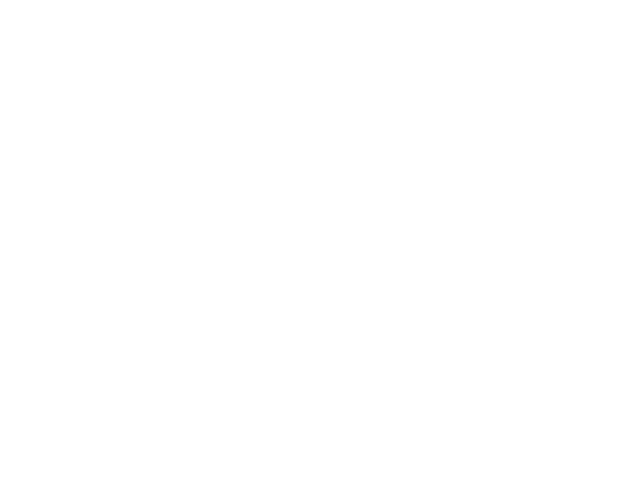

<AxesSubplot:xlabel='yhat', ylabel='y'>

In [54]:
%matplotlib notebook
df_rural = pd.DataFrame({'y':log_rural,'yhat':result_rural.get_predicted_log_expenditures()})
df_rural.plot.scatter(x='yhat',y='y')

<IPython.core.display.Javascript object>


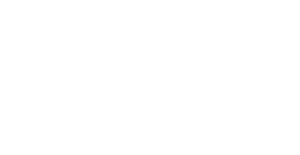

<AxesSubplot:xlabel='yhat', ylabel='y'>

In [55]:
%matplotlib notebook
df_urban = pd.DataFrame({'y':log_urban,'yhat':result_urban.get_predicted_log_expenditures()})
df_urban.plot.scatter(x='yhat',y='y')

<IPython.core.display.Javascript object>


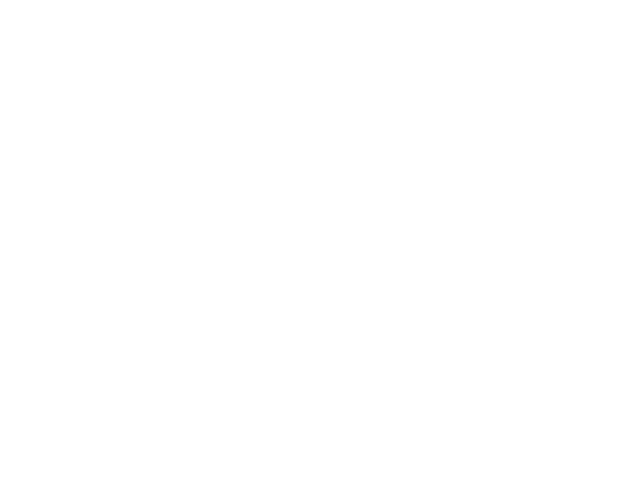

<AxesSubplot:xlabel='yhat', ylabel='y'>

In [56]:
%matplotlib notebook
df_capital = pd.DataFrame({'y':log_capital,'yhat':result_capital.get_predicted_log_expenditures()})
df_capital.plot.scatter(x='yhat',y='y')

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.



### Parameters



#### (Relative) Income Elasticity



Some of the parameters have an interesting interpretation.  First among these are the $\beta$ coefficients, which govern how *income elastic* different goods are (higher values means more elastic).  These are also called *Frisch elasticities*.



In [57]:
result_rural.get_beta().sort_values()

j
Cassava fresh                                            0.149389
Maize (flour)                                            0.153971
Irish potatoes                                           0.268086
Sweet potatoes                                           0.284773
Goat meat                                                0.330513
Tea (dry)                                                0.330865
Soft drinks                                              0.342690
Plantains                                                0.376571
Coconuts                                                 0.383230
Groundnuts                                               0.390270
Peas, beans, lentils and other pulses                    0.394395
Rice (husked)                                            0.427673
Beef                                                     0.444977
Dried/salted/canned fish                                 0.446299
Fresh fish                                               0.486351
Cooking 

In [58]:
result_urban.get_beta().sort_values()

j
Maize (flour)                                            0.141471
Tea (dry)                                                0.172998
Pasta                                                    0.228784
Cassava fresh                                            0.279721
Sweet potatoes                                           0.309235
Peas, beans, lentils and other pulses                    0.371869
Plantains                                                0.390284
Cooking oil                                              0.394499
Fresh milk                                               0.402689
Soft drinks                                              0.411397
Groundnuts                                               0.416080
Dried/salted/canned fish                                 0.417341
Beef                                                     0.438168
Rice (husked)                                            0.439327
Pastries                                                 0.453165
Irish po

In [59]:
result_capital.get_beta().sort_values()

j
Maize (flour)                                            -0.069812
Tea (dry)                                                 0.008569
Pastries                                                  0.130796
Peas, beans, lentils and other pulses                     0.202262
Pasta                                                     0.232715
Rice (husked)                                             0.277141
Sweet potatoes                                            0.282542
Cooking oil                                               0.284164
Coconuts                                                  0.291577
Groundnuts                                                0.311065
Plantains                                                 0.317328
Dried/salted/canned fish                                  0.334597
Other spices                                              0.359494
Onions, tomatoes, carrots, green pepper, other viungo     0.359723
Beef                                                      0.

Here we use a plot to visualize, with confidence intervals.



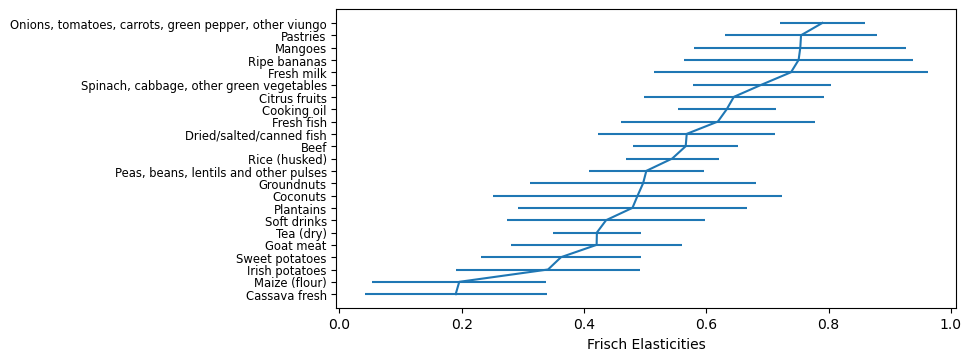

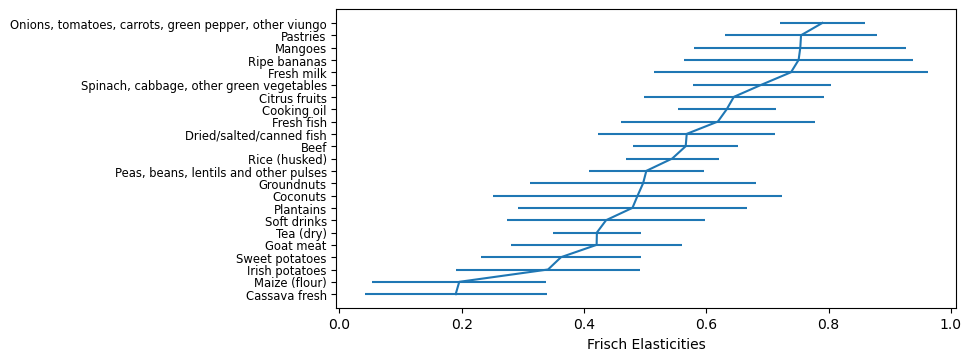

In [78]:
result_rural.graph_beta()

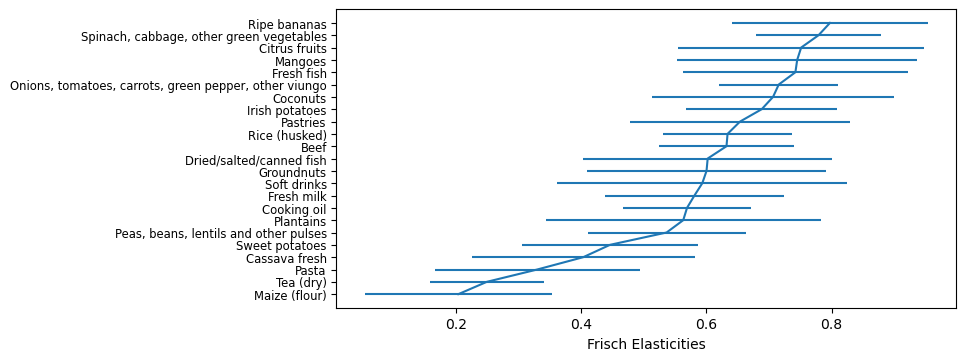

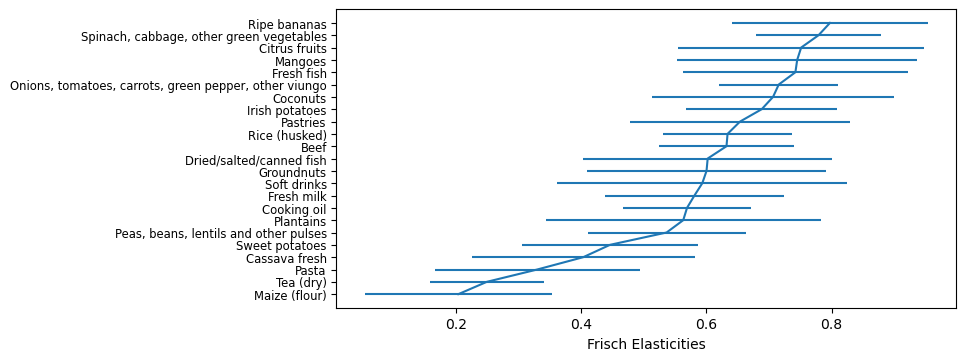

In [79]:
result_urban.graph_beta()

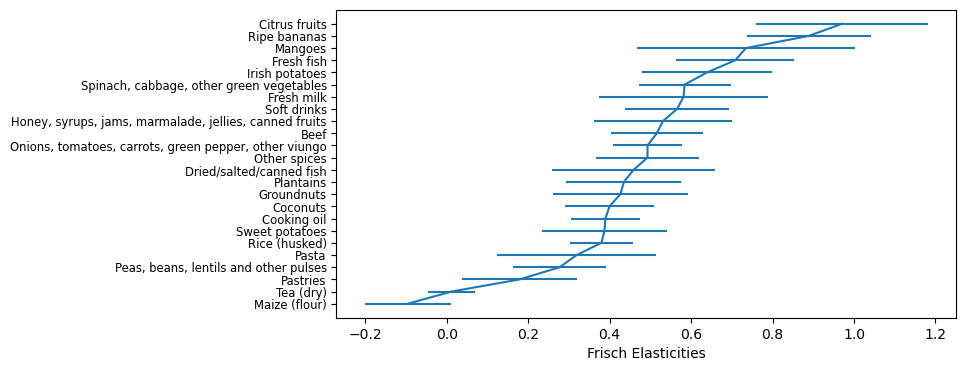

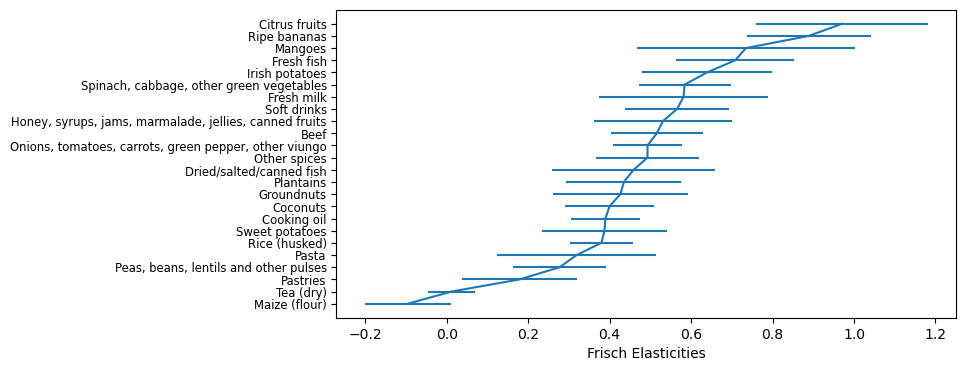

In [80]:
result_capital.graph_beta()

#### Demand and Household Composition



We&rsquo;re particularly interested in the effects of household composition on demand.  These are captured by the $\gamma_j$ parameters in the regression.



In [63]:
result_rural.gamma

k,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize,Rural,Constant
j,,,,,,,,,,,,,,,,,
Beef,-0.018440,0.048819,0.048971,0.062807,0.119483,0.124571,0.094546,-0.033053,0.050153,0.018923,0.084398,0.072538,0.208029,0.161689,-0.149373,-0.176001,-0.176001
Cassava fresh,0.083658,0.052565,0.123656,0.059618,0.090549,0.028143,0.263954,0.051091,-0.032318,0.057977,0.118254,0.030221,0.081467,0.197885,-0.129222,-0.150555,-0.150555
Citrus fruits,-0.038002,-0.025017,0.004748,-0.023600,0.014169,-0.017547,-0.072908,-0.094709,-0.086576,0.083760,-0.001671,0.047769,0.142132,0.128331,0.336206,-0.383528,-0.383528
Coconuts,-0.059189,-0.054400,-0.103124,-0.074861,-0.069377,-0.143443,0.033634,-0.051213,-0.065418,-0.101570,-0.055377,-0.047945,-0.124207,-0.001707,0.214394,-0.042197,-0.042197
Cooking oil,-0.025104,0.017079,0.027734,0.073772,0.135137,0.120466,-0.011802,-0.057470,0.016351,0.033958,0.070607,0.089003,0.131912,0.060583,-0.032357,-0.158668,-0.158668
Dried/salted/canned fish,0.046267,-0.035822,0.000961,-0.031363,0.093871,0.109375,-0.025473,-0.024031,-0.016465,0.044263,0.051326,0.042375,0.054933,0.049500,0.256215,-0.357958,-0.357958
Fresh fish,0.014765,0.011333,0.061849,0.046047,0.135353,0.128557,0.064090,-0.012975,-0.038122,-0.026483,0.018787,0.053420,0.152530,0.064439,0.132822,-0.298018,-0.298018
Fresh milk,-0.049938,-0.016027,-0.030848,0.031492,0.101952,0.013400,0.006400,-0.011000,-0.043562,-0.008987,0.077231,-0.001319,0.115020,0.047540,0.262893,-0.374811,-0.374811
Goat meat,-0.006462,0.033967,0.097078,0.060911,0.087537,0.101930,0.119278,-0.026725,0.071004,0.024450,-0.045795,0.166562,0.032463,0.033961,0.091178,-0.315348,-0.315348


In [64]:
result_urban.gamma

k,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize,Rural,Constant
j,,,,,,,,,,,,,,,,,
Beef,-0.062446,-0.070234,-0.047866,0.057020,0.037527,0.022328,-0.022268,-0.131537,-0.036409,-0.034651,0.034747,0.026917,0.097951,0.075051,0.469048,-0.049368,-0.925565
Cassava fresh,-0.030969,0.017064,0.198623,-0.142137,-0.038257,-0.099343,0.006000,-0.057398,0.034578,0.133997,0.011945,0.081791,0.132429,0.174437,0.247707,0.068626,-0.579367
Citrus fruits,0.101916,-0.053898,0.020085,0.032518,0.026241,-0.108647,-0.080976,-0.130944,-0.106177,-0.060583,0.092986,0.036449,0.087493,-0.036565,0.466370,-0.057683,-0.861518
Coconuts,0.154450,0.100530,0.005071,0.147144,0.051676,0.135947,0.229035,0.223906,0.181686,0.232459,0.247778,0.168781,0.252699,0.247442,-0.604623,-0.134914,-0.087060
Cooking oil,-0.024251,0.012375,-0.042553,0.100712,0.136153,0.097609,-0.013766,-0.140247,-0.011094,0.019086,0.072477,0.011797,0.064573,0.010182,0.333991,-0.110605,-0.773651
Dried/salted/canned fish,-0.010761,0.040564,0.035838,0.008096,0.073746,0.108574,0.051929,-0.006805,-0.025515,0.022964,0.031200,0.035252,0.153312,0.074962,0.233139,-0.192896,-0.671161
Fresh fish,0.035297,0.019673,0.034617,0.085765,0.251329,0.250201,-0.025665,-0.110067,-0.079843,0.067850,-0.044045,0.041629,0.112580,-0.078317,0.339995,-0.242246,-1.001715
Fresh milk,0.242759,0.043181,0.027383,0.078727,0.218970,-0.095444,-0.267630,0.100069,-0.020493,0.202184,0.073498,0.104836,0.085342,0.161175,-0.027777,-0.274591,-0.477209
Groundnuts,0.196227,0.077056,0.117840,0.063410,0.068866,0.083393,-0.049924,0.067051,0.078138,0.116186,0.150915,0.119473,0.195646,0.290788,-0.394456,-0.053823,-0.004158


In [65]:
result_capital.gamma

k,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize,Rural,Constant
j,,,,,,,,,,,,,,,,,
Beef,-0.063178,0.049240,-0.010731,0.113784,0.026154,-0.134615,-0.022182,0.059335,0.072488,-0.097050,0.024636,0.045117,0.048839,0.159714,0.495174,-0.248581,-0.947701
Citrus fruits,-0.068366,-0.150060,-0.065433,0.071435,0.035236,0.046401,-0.017843,0.008257,-0.056478,0.071757,-0.006018,0.007911,0.066832,-0.226263,0.577411,-0.040465,-1.035887
Coconuts,0.102761,0.042579,0.011225,0.093762,0.041464,-0.005029,0.018105,0.013925,0.121876,0.049790,0.024037,0.077870,0.102856,0.014572,0.302965,-0.050763,-0.838301
Cooking oil,0.015812,0.006301,-0.042803,0.105036,0.066989,-0.064126,0.012532,0.054568,0.091353,0.021029,0.039923,0.033747,0.117332,0.101056,0.286441,-0.032956,-0.714605
Dried/salted/canned fish,0.161514,0.033615,0.173450,0.002653,0.023559,0.021552,-0.049606,-0.168220,0.094601,-0.083317,-0.180785,0.191090,0.024082,-0.121630,0.390113,0.027244,-0.797717
Fresh fish,-0.093718,-0.024423,-0.184728,0.077265,0.046418,-0.007272,-0.015176,-0.113163,0.056300,-0.078323,-0.133056,0.011886,0.123429,0.143946,0.557979,-0.303280,-0.989602
Fresh milk,-0.088032,-0.040045,0.047146,0.004914,-0.003410,-0.066916,-0.171901,-0.065161,0.139404,0.103405,-0.118333,-0.075492,-0.080011,-0.006361,0.466951,0.628352,-0.754477
Groundnuts,-0.136061,-0.116851,-0.072603,0.219464,-0.222651,-0.121010,0.120290,-0.129199,0.135589,-0.210862,-0.221238,-0.063528,0.139864,0.106734,0.761618,0.148284,-1.059163
"Honey, syrups, jams, marmalade, jellies, canned fruits",-0.140036,-0.015897,-0.035656,0.176983,0.061913,-0.122026,-0.154596,-0.047045,-0.038205,-0.083035,-0.096774,0.012252,0.197851,-0.022772,0.473869,-0.641243,-0.930856


In [82]:
result_rural.w

i      t        m             
1      2012-13  Mainland Rural   -1.699784
       2014-15  Mainland Rural   -1.214186
1001   2012-13  Mainland Rural   -2.072927
1002   2012-13  Mainland Rural   -1.239184
10032  2014-15  Mainland Rural   -2.257651
                                    ...   
9904   2014-15  Mainland Rural    0.524803
       2019-20  Mainland Rural   -1.133039
991    2012-13  Mainland Rural   -0.274123
993    2012-13  Mainland Rural   -3.120317
995    2012-13  Mainland Rural   -2.335328
Length: 3688, dtype: float64

<AxesSubplot:>

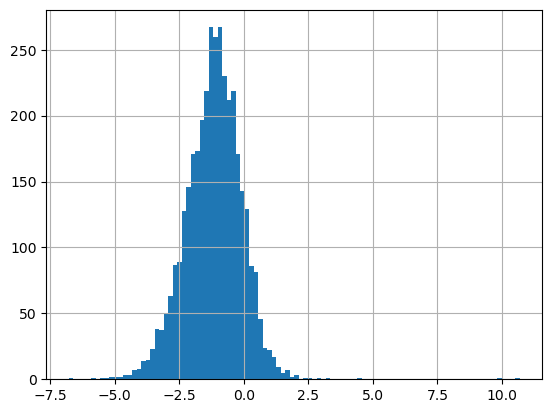

In [66]:
%matplotlib inline
result_rural.w.hist(bins=100)

<AxesSubplot:>

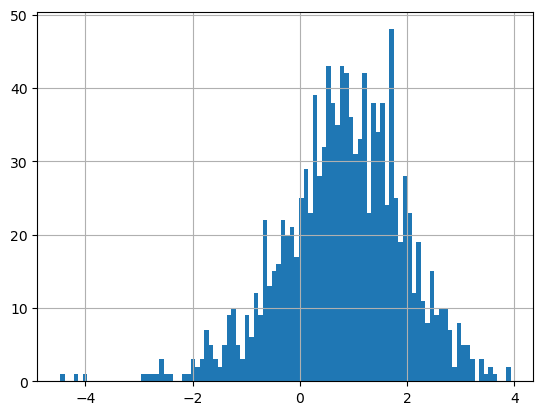

In [67]:
%matplotlib inline
result_urban.w.hist(bins=100)

<AxesSubplot:>

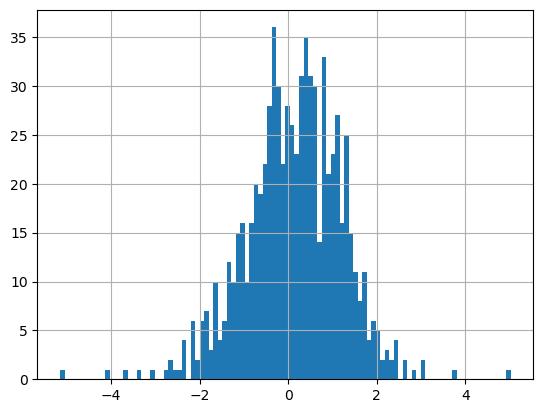

In [68]:
%matplotlib inline
result_capital.w.hist(bins=100)

### Saving Result



You can save the estimated result, using something like



In [69]:
#result.to_pickle('my_estimates.pickle')

You can subsequently load this using



In [70]:
import cfe
#result = cfe.regression.read_pickle('my_estimates.pickle')

# Nutritional Adequacy of Diet

In [71]:
consumption = read_sheets('https://docs.google.com/spreadsheets/d/1eRq1SbS5xTBkTzpjxLQLAKQ-j4o5UVp4mhHZSsn8K0M/edit#gid=1674215724',sheet='Consumption')
consumption.columns = ['i','t','m','j','units','quant_ttl_consume']

consumption_rural = consumption.where(consumption['m']=="Mainland Rural").dropna()
consumption_rural['j'] = consumption_rural['j'].str.lower()
consumption_rural = consumption_rural.pivot_table(values='quant_ttl_consume', index=['i','t','m'], columns='j', aggfunc='first').reset_index()
consumption_rural = consumption_rural.drop([''],axis=1)

consumption_urban = consumption.where(consumption['m']=="Mainland Other Urban").dropna()
consumption_urban['j'] = consumption_urban['j'].str.lower()
consumption_urban = consumption_urban.pivot_table(values='quant_ttl_consume', index=['i','t','m'], columns='j', aggfunc='first').reset_index()
consumption_urban = consumption_urban.drop([''],axis=1)

consumption_capital = consumption.where(consumption['m']=="Dar Es Salaam").dropna()
consumption_capital['j'] = consumption_capital['j'].str.lower()
consumption_capital = consumption_capital.pivot_table(values='quant_ttl_consume', index=['i','t','m'], columns='j', aggfunc='first').reset_index()
consumption_capital = consumption_capital.drop([''],axis=1)

Key available for students@eep153.iam.gserviceaccount.com.


In [72]:
nutrition = read_sheets('https://docs.google.com/spreadsheets/d/18EuF3OLGDB6-hb9PToJzDMfyvN8cDqEpzPmQl9leJBU/edit#gid=1385026268',sheet='For Use in Code')
nutrition['Item name'] = nutrition['Item name'].str.lower()
nutrition = nutrition.sort_values(by=['Item name']).drop(['Value'],axis=1).set_index('Item name').transpose()

Key available for students@eep153.iam.gserviceaccount.com.


In [73]:
pd.set_option('display.max_columns', None)

In [74]:
nutrition.head(2)

Item name,"amranth, leaves raw / canned, dried and wild vegetables",beef including minced sausage,bottled beer,"bread, white",butter refined - ghee,cake,canned milk/milk powder,cashew (almonds and other nuts),cassava dry/flour,"cassava fresh, raw",chicken and other poultry,coconuts (mature/immature),coffee and cocoa,cooking bananas (/plantains),cooking oil (vegetable oil),cream cheese (milk products),cricket (other domestic/wild meat products),dried/salted/canned fish and seafood (including dagaa),eggs,fish,fresh milk,goat meat,groundnuts in shell/shelled,"honey (/syrups, jams, marmalade, jellies, canned fruits)",instant coffee,"irish potatoes, cooked (english)","lentil, cooked / peas (/beans, lentils and other pulses)",local beer,macaroni (/spaghetti),maida (wheat),"maize (flour, dry)","maize (grain, dry, raw)","maize (green, cob, immature)","mango juice (soda, juice, water)",mangoes (other fruits),millet and sorghum (flour),millet and sorghum (grain),"onion, raw (/tomatoes, carrots and green pepper, other viungo)",oranges (citrus fruits),other cereal products,other raw materials for drinks,other spices,other starches (edible),pork including sausages and bacon,raw fresh fish and seafood (including dagaa),rice (husked) (white grain raw),rice (paddy),ripe bananas,salt,"spinach, cooked (/cabbage and other green vegetables)",sugar,sugarcane,sunflower seed / seeds and products from nuts/seeds (excl. cooking oil),"sweet potatoes, fresh ap","sweets (candy, chocolate)",tea dry,vinegar (wine and spirits),wheat flour (whole grain),wild birds and insects,yams/cocoyams raw
energy kcal,23.0,323.0,41.0,274.0,876.0,320.0,496.0,589.0,314.0,160.0,167.0,70.0,200.0,NaN,862.0,349.0,7.5,309.0,278.0,98.0,60.0,269.0,567.0,304.0,200.0,93.0,116.0,41.0,371.0,349.0,362.0,362.0,59.0,54.0,65.0,328.0,328.0,40.0,47.0,NaN,NaN,NaN,381.0,537.0,112.0,358.0,358.0,89.0,0.0,23.0,387.0,26.0,588.0,74.0,479.0,1.0,19.0,399.0,NaN,97.0
protein g,8.5,24.9,0.3,8.0,0.3,4.7,26.3,20.0,2.6,1.4,24.5,0.5,10.0,NaN,0.0,7.6,9.6,66.4,19.2,18.1,3.2,24.9,25.8,0.3,10.0,2.0,9.0,0.3,10.5,12.3,8.1,8.1,1.8,0.2,0.5,6.6,6.6,1.3,0.9,NaN,NaN,NaN,0.3,19.6,21.4,6.5,6.5,1.1,0.0,3.0,0.0,0.0,26.4,1.2,4.2,0.0,0.0,13.7,NaN,2.1


In [75]:
consumption_rural.head(2)

j,i,t,m,beef,bottled beer,bread,butter,canned milk/milk powder,"canned, dried and wild vegetables",cassava dry/flour,cassava fresh,chicken,citrus fruits,coconuts,coffee and cocoa,cooking oil,cricket,dairy,dried/salted/canned fish,eggs,fish,fresh fish,fresh milk,goat meat,groundnuts,"honey, syrups, jams, marmalade, jellies, canned fruits",irish potatoes,local beer,maize (flour),maize (grain),"maize (green, cob)",mangoes,millet and sorghum (flour),millet and sorghum (grain),nuts,"onions, tomatoes, carrots, green pepper, other viungo",other cereal products,other raw materials for drinks,other spices,other starches,pasta,pastries,"peas, beans, lentils and other pulses",plantains,pork,"prepared tea, coffee",rice (husked),rice (paddy),ripe bananas,salt,seeds and nut products,soft drinks,"spinach, cabbage, other green vegetables",sugar,sugarcane,sweet potatoes,sweets,tea (dry),wheat (flour),"wheat, barley, grain, and other cereals","wheat, barley, other grains",wild birds and insects,wine and spirits,yams/cocoyams
0,1,2008-09,Mainland Rural,1.0,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,0.06,NaN,NaN,0.05,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.08,NaN,NaN,0.8,0.50,NaN,NaN,NaN,0.009,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2010-11,Mainland Rural,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,0.50,NaN,NaN,0.25,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5,8.0,NaN,NaN,1.2,NaN,NaN,NaN,NaN,NaN,0.4,1.0,NaN,NaN,NaN,4.5,NaN,NaN,0.50,NaN,NaN,0.9,1.75,NaN,NaN,NaN,0.030,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
pd.reset_option('display.max_columns')

In [77]:
# Create separate dataframe with nutritional categories as titles
# Cross multiply + sum consumption and nutrition to get total nutrition values
# Store values in separate dataframe